# Embedd data in control cells UMAP representation

In [1]:
import numpy as np
import anndata as ad
import pandas as pd
from matplotlib import rcParams
import scanpy as sc

import umap.umap_ as umap
import umap.plot

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import os
import config as general_paths

import warnings
warnings.filterwarnings("ignore")

/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ilosz01/anaconda3/envs/scs/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
figure_path = general_paths.figures_path
data_path = general_paths.data_path
output_path = general_paths.output_path
local_path = general_paths.local_path
input_path = output_path

In [3]:
NO_PCA = 20
NO_NEIGHBORS = 15
SELECTED_LOUVAIN = 'louvain_r1'
HOW_MANY_HIGHLY_VARIABLE_GENES = 16000

## Read data

In [4]:
campari_umap_file = 'campari_umap_from_kallisto.h5ad'
adata_all_path = os.path.join(input_path,campari_umap_file)

control_umap_file = 'control_umap_from_kallisto.h5ad'
adata_control_path = os.path.join(input_path,control_umap_file)

In [5]:
adata_all = ad.read_h5ad(adata_all_path)
adata_control = ad.read_h5ad(adata_control_path)

In [6]:
adata_all

AnnData object with n_obs × n_vars = 2126 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
adata_control

AnnData object with n_obs × n_vars = 606 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Create separate adata object for all other stimuli

In [8]:
# Select only the cells where stimulus was not 0 (control)
adata_stim = adata_all[adata_all.obs['stimulus'] != 0]
adata_stim

View of AnnData object with n_obs × n_vars = 1520 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
adata_stim.raw.X

<1520x21764 sparse matrix of type '<class 'numpy.float64'>'
	with 13345816 stored elements in Compressed Sparse Row format>

In [10]:
# go back to raw data
adata_stim = adata_stim.raw.to_adata() # (it is already nromalized and log transformed)

In [11]:
# save all normalized and log transformed in raw slot.
adata_stim.raw = adata_stim

In [12]:
adata_stim

AnnData object with n_obs × n_vars = 1520 × 21764
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [13]:
# select only highly variable genes
sc.pp.highly_variable_genes(adata_stim, flavor='cell_ranger', n_top_genes=HOW_MANY_HIGHLY_VARIABLE_GENES) # kan add batch-key; better do that per batch

In [14]:
adata_stim = adata_stim[:, adata_stim.var.highly_variable] # select and keep only those high variable genes

In [15]:
adata_stim

View of AnnData object with n_obs × n_vars = 1520 × 16000
    obs: 'sample', 'stimulus', 'red', 'green', 'well_id', 'plate_number', 'batch', 'stimulus_name', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'to_exclude', 'plate_str', 'louvain_r0.5', 'louvain_r1', 'louvain_r1.5', 'louvain_r2', 'louvain_r2.5'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'louvain_r1_colors', 'louvain_r2.5_colors', 'louvain_r2_colors', 'neighbors', 'pca', 'plate_str_colors', 'sample_colors', 'stimulus_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [16]:
sc.pp.regress_out(adata_stim, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_stim, max_value=10)

PCA for stim only

In [17]:
# # Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
# sc.tl.pca(adata_stim, use_highly_variable=True, svd_solver='arpack')

In [18]:
# # Let us inspect the contribution of single PCs to the total variance in the data. 
# # This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function
# sc.pl.pca_variance_ratio(adata_stim, log=True)

In [19]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix
# sc.pp.neighbors(adata_stim, n_neighbors=15, n_pcs=NO_PCA)

In [20]:
# We suggest embedding the graph in two dimensions using UMAP 
# sc.tl.umap(adata_stim)

In [21]:
# You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw
# sc.pl.umap(adata_stim, color='n_counts', use_raw=False)

## Create and save new umap transformation for control data

In [34]:
# get control count matrix
control_data = adata_control.X

In [35]:
# these are my cluster labels
my_labels = adata_control.obs[SELECTED_LOUVAIN]
# for the scatter plot colormap we need labels as intigers or colors
clusters_control = [int(el) for el in my_labels.values]
NO_clusters = len(np.unique(clusters_control))

In [36]:
# Do PCA first
# 50 PCA was default in scanpy
pca_control = PCA(n_components=50, svd_solver='arpack')
pca_control_representation = pca_control.fit_transform(control_data)

Text(0.5, 1.0, 'variance ratio')

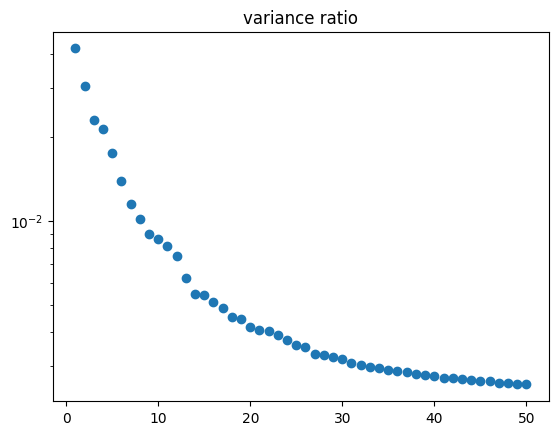

In [37]:
# pca.explained_variance_ratio_
plt.scatter([i+1 for i in range(50)],pca_control.explained_variance_ratio_)
plt.yscale('log')
plt.title("variance ratio")

In [38]:
# keep only as many as in scanpy (NO_PCA)
pca_control_representation = pca_control_representation[:,:NO_PCA]
pca_control_representation.shape

(606, 20)

In [39]:
# construct a UMAP object
umap_control = umap.UMAP(n_components= 2,
                    n_neighbors=NO_NEIGHBORS,
                    min_dist = 0.5,
                    # spread= 1.0, 
                    # init= 'spectral', 
                    # negative_sample_rate=5,
                    random_state=0).fit(pca_control_representation)

umap_control.embedding_.shape

(606, 2)

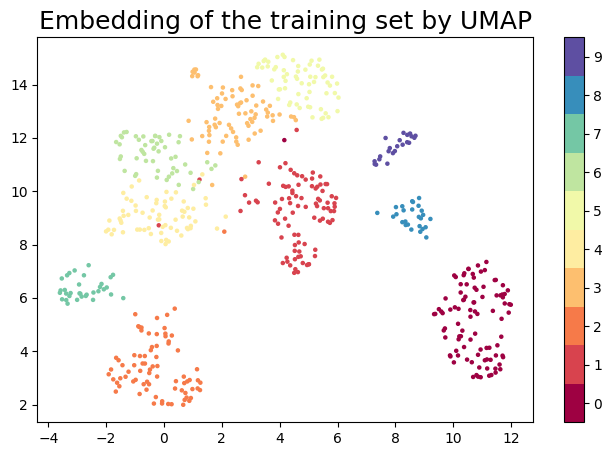

In [42]:
rcParams['figure.figsize']=(8,5)
plt.scatter(umap_control.embedding_[:, 0], umap_control.embedding_[:, 1], s= 5, c=clusters_control, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=18)
plt.colorbar(boundaries=np.arange(NO_clusters+1)-0.5).set_ticks(np.arange(NO_clusters))